# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of a traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

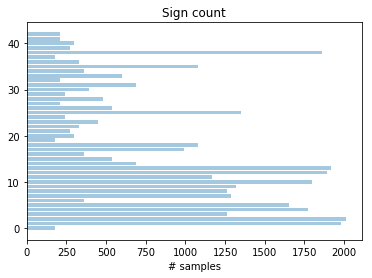

38


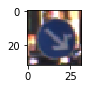

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import scipy.ndimage

# Visualizations will be shown in the notebook.
%matplotlib inline
label_freq = np.bincount(y_train)
max_inputs = np.max(label_freq)

plt.barh(np.arange(n_classes), label_freq, align='center', alpha=0.4)

plt.xlabel('# samples')
plt.title('Sign count')

plt.show()

index = random.randint(0, len(X_train))
image = X_train[index]
plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [4]:
# retrieve class labels 
import csv
with open('signnames.csv', 'r') as file:
    reader = csv.reader(file)
    class_names = dict(reader)
    
# take a random sample per class
sample_image_per_class = []
for n in range(n_classes):
    sample_image_per_class.append(np.random.choice(np.where(y_train==n)[0]))
    
show_images = X_train[sample_image_per_class,:,:,:]


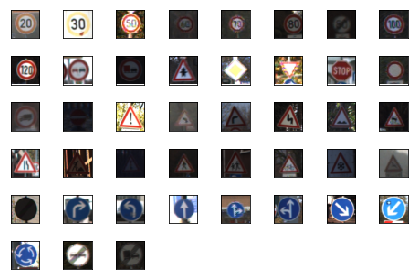

In [5]:
#show sign per class
def show_signs(image_array, width, height):
    fig = plt.figure()
    for j in range(image_array.shape[0]):
        ax = fig.add_subplot(height, width, j+1)
        ax.imshow(image_array[j], cmap='gray')
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()
    
show_signs(show_images, 8, 6)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

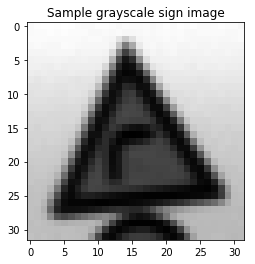

In [6]:
import cv2
from copy import deepcopy

#convert the images to grayscale
X_train_gr = [cv2.cvtColor(X_train[n], cv2.COLOR_BGR2GRAY)
              for n in range(np.shape(X_train)[0])]
X_test_gr = [cv2.cvtColor(X_test[n], cv2.COLOR_BGR2GRAY)
             for n in range(np.shape(X_test)[0])]
    
y_train_gr = deepcopy(y_train)

plt.imshow(random.choice(X_train_gr), cmap='gray')
plt.title('Sample grayscale sign image')
plt.show()


###Generate Additional Data

In [7]:
# functions to transform the images
# trasformation 1
def trans_1(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[0,0],[32,5],[0,32],[32,27]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 2
def trans_2(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[0,5],[32,0],[0,27],[32,32]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 3
def trans_3(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[5,0],[27,0],[0,32],[32,32]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 4 - skew image 1
def trans_4(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[0,0],[27,5],[5,32],[32,27]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 5 - skew image 2
def trans_5(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[5,5],[32,0],[0,27],[27,32]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# transformation 6 - rotation +5 to +15
def trans_6(image):
    # chose rotation angle randomly from a uniform distribution
    rot_ang = int(np.random.uniform(10)) + 5
    M = cv2.getRotationMatrix2D((16,16),rot_ang,1)
    dst = cv2.warpAffine(image,M,(32,32))
    return dst## visualize the transformations to be performed on the dataset


# transformation 7 - rotation -5 to -15
def trans_7(image):

    # chose rotation angle randomly from a uniform distribution
    rot_ang = int(np.random.uniform(-10)) - 5
    M = cv2.getRotationMatrix2D((16,16),rot_ang,1)
    dst = cv2.warpAffine(image,M,(32,32))
    return dst

Transformations performed for data augmentation:


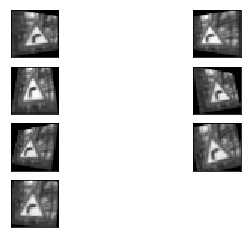

In [8]:
## visualize the transformations to be performed on the dataset
sample_im = random.choice(X_train_gr)

transformations = [trans_1, trans_2, trans_3, trans_4, trans_5, trans_6, trans_7]

for i, tr in enumerate(transformations):
    transformed = tr(sample_im)
    plt.subplot(4,2,i+1)
    plt.imshow(transformed, cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

print('Transformations performed for data augmentation:')

In [9]:
# global variable to keep all original dataset and add augmented dataset
all_X_train = deepcopy(X_train_gr)
all_y_train = deepcopy(y_train_gr)
    
## use data augmentation to beef up classes that has low frequencies

# augment data function:
def augment_data(augment_fn, X_data,y_data):
    global all_X_train
    global all_y_train
   
    print('old shape:')
    print(np.shape(all_y_train))

    class_freq = np.bincount(all_y_train)

    mean_freq = int(np.average(class_freq))
    print('mean frequency:', mean_freq)

    transform_X = []
    transform_y = []
    for i, im in enumerate(X_data):
        if class_freq[y_data[i]] < mean_freq:
            im_trans = augment_fn(im)
            transform_X.append(im)
            transform_y.append(y_data[i])

    all_X_train = np.append(all_X_train, transform_X, axis=0)
    all_y_train = np.append(all_y_train, transform_y, axis=0)

    print('new shape:')
    print(np.shape(all_X_train))
    print(np.shape(all_y_train))

    class_freq = np.bincount(all_y_train)
    display_image_id = 1000

    plt.figure(1)
    n = np.size(class_freq)

    index = np.arange(np.shape(class_freq)[0])
    plt.bar(index, class_freq, 1)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.show

old shape:
(34799,)
mean frequency: 809
new shape:
(43918, 32, 32)
(43918,)
old shape:
(43918,)
mean frequency: 1021
new shape:
(50968, 32, 32)
(50968,)
old shape:
(50968,)
mean frequency: 1185
new shape:
(60508, 32, 32)
(60508,)
old shape:
(60508,)
mean frequency: 1407
new shape:
(73077, 32, 32)
(73077,)
old shape:
(73077,)
mean frequency: 1699
new shape:
(81417, 32, 32)
(81417,)
old shape:
(81417,)
mean frequency: 1893
new shape:
(93866, 32, 32)
(93866,)
old shape:
(93866,)
mean frequency: 2182
new shape:
(110996, 32, 32)
(110996,)


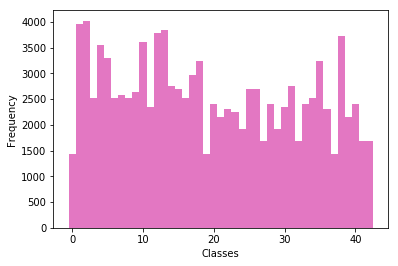

In [10]:
# augmentation 
augment_data(trans_1, X_train_gr, y_train_gr)
augment_data(trans_2, X_train_gr, y_train_gr)
augment_data(trans_3, X_train_gr, y_train_gr)
augment_data(trans_4, X_train_gr, y_train_gr)
augment_data(trans_5, X_train_gr, y_train_gr)
augment_data(trans_6, X_train_gr, y_train_gr)
augment_data(trans_7, X_train_gr, y_train_gr)

### Split the data into training/validation/testing sets.


In [11]:
# empty arrays for new training and validation datasets
new_X_train = []
new_y_train = []

new_X_val = []
new_y_val = []

for n in range(n_classes):
    # find indexes of each classes in the dataset
    # randomly choose from and make up a validation set for each class
    where_id = np.where(all_y_train==n)[0]
    np.random.shuffle(where_id)
    
    # make training data 80% of orginal dataset
    cut_off = 0.75
    new_X_train.append(all_X_train[where_id][:int(np.shape(where_id)[0]*cut_off)])
    new_X_val.append(all_X_train[where_id][int(np.shape(where_id)[0]*cut_off):])
    
    new_y_train.append(all_y_train[where_id][:int(np.shape(where_id)[0]*cut_off)])
    new_y_val.append(all_y_train[where_id][int(np.shape(where_id)[0]*cut_off):])
else:
    # stack up training and validation sets
    new_X_train = np.vstack(new_X_train)
    new_X_val = np.vstack(new_X_val)
    new_y_train = np.hstack(new_y_train)
    new_y_val = np.hstack(new_y_val)
    
# confirm shape of datasets made
print('shape of training data',np.shape(new_X_train))
print('shape of validation data', np.shape(new_X_val))

shape of training data (83245, 32, 32)
shape of validation data (27751, 32, 32)


In [12]:
print('Creating network architecture...')
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# inputs and parameters
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

# keep probability for dropout
keep_prob = tf.placeholder(tf.float32)

# one-hot encode the labels
one_hot_y = tf.one_hot(y, 43)

# learning rate
l_rate = 0.001

Creating network architecture...


In [13]:
# define archtecture
def signs_classify(x, keep_prob):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 24), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(24))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation 1.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 12x12x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 24, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation 2.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 14x14x32. Output = 7x7x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 3: Convolutional. Output = 7x7x64.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Activation 3.
    conv3 = tf.nn.relu(conv3)

    # Pooling. Input = 5x5x64. Output = 2x2x64.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 2x2x64. Output = 256.
    fc0   = flatten(conv3)
    
    # Layer 3: Fully Connected. Input = 256. Output = 512.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(256, 512), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(512))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation 3.
    fc1    = tf.nn.relu(fc1)
    
    # dropout 1
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 512. Output = 256.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, 256), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(256))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation 4.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Output Layer: Fully Connected. Input = 256. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(256, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits    

In [14]:
# training functions
logits = signs_classify(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
# compute the mean over all samples
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = l_rate)
training_operation = optimizer.minimize(loss_operation)

In [15]:
# model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data, drop_out):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: drop_out})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [16]:
# reshape dataset to suitable input for network
new_X_train = np.reshape(new_X_train, (np.shape(new_X_train)[0],32,32,1))
new_X_val = np.reshape(new_X_val, (np.shape(new_X_val)[0],32,32,1))

# normalize dataset [naive]
new_X_train = (np.array(new_X_train) - 128.0)/256.0
new_X_val = (np.array(new_X_val) - 128.0)/256.0

In [17]:
from sklearn.utils import shuffle

save_file = './sign_classify.ckpt'
EPOCHS = 15
BATCH_SIZE = 128
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(new_X_train, new_y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
        validation_accuracy = evaluate(new_X_val, new_y_val, drop_out=1.0)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, save_file)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.862

EPOCH 2 ...
Validation Accuracy = 0.956

EPOCH 3 ...
Validation Accuracy = 0.976

EPOCH 4 ...
Validation Accuracy = 0.986

EPOCH 5 ...
Validation Accuracy = 0.989

EPOCH 6 ...
Validation Accuracy = 0.991

EPOCH 7 ...
Validation Accuracy = 0.993

EPOCH 8 ...
Validation Accuracy = 0.995

EPOCH 9 ...
Validation Accuracy = 0.996

EPOCH 10 ...
Validation Accuracy = 0.995

EPOCH 11 ...
Validation Accuracy = 0.996

EPOCH 12 ...
Validation Accuracy = 0.998

EPOCH 13 ...
Validation Accuracy = 0.998

EPOCH 14 ...
Validation Accuracy = 0.997

EPOCH 15 ...
Validation Accuracy = 0.995

Model saved


In [18]:
new_X_test = np.reshape(X_test_gr, (np.shape(X_test_gr)[0],32,32,1))

# normalize dataset [naive]
new_X_test = (np.array(new_X_test) - 128.0)/256.0

meta_graph_file = save_file+'.meta'

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(meta_graph_file)
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # model evaluation
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    test_accuracy = sess.run(
        accuracy_operation,
        feed_dict={x: new_X_test, y: y_test, keep_prob: 1.0})

print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.9400638341903687


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
I transformed the images from RGB format to grayscale as the features for the signs are independant from their colors.


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I built the validation set choosing 25% random data from each class.
I've generated addionatl data transforming the images applying some common methods: perspective transforms, skew tranforms and little rotations.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
Starting from LeNet from the lessons and experimenting:

Layer 1: Convolution of 5x5 kernel, 1 stride and 24 feature maps
Activation: ReLU Pooling 1: 2x2 kernel and 2 stride
Layer 2: Convolution of 3x3 kernel, 1 stride and 32 feature maps 
Activation: ReLU Pooling 2: 2x2 kernel and 2 stride
Layer 3: Convolution of 3x3 kernel, 1 stride and 64 feature maps 
Activation: ReLU Pooling 2: 2x2 kernel and 2 stride
Layer 3: Fully connected layer with 512 units Activation: ReLU
Layer 4: Fully connected layer with 256 units Activation: ReLU
Output Layer: Fully connected layer with 43 units for logits(network) output 
Activation: Softmax


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

To train the model I used:

Optimizer: Adam optimizer with learning rate of 0.001
Batch size: 128
Epochs: 15
Hyperparameters: Weight initialization with mean of 0 and standard deviation of 0.1, Dropout keep-probability of 0.5 for training and 1.0 for evaluation



### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I started using the LeNet model making some experiments with parameters. I've used the Adam Optimizer beacuse it was performing well beign adaptive.
Started with big number of epochs (30) but with lower epochs near to 10 I had an 0.95 accuracy.
I've choosed dropout kp 0.50 for training and 1 for validation to prevent overfitting.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Prediction: 1 	| Speed limit (30km/h)
Prediction: 39 	| Keep left
Prediction: 26 	| Traffic signals
Prediction: 11 	| Right-of-way at the next intersection
Prediction: 18 	| General caution
Prediction: 34 	| Turn left ahead


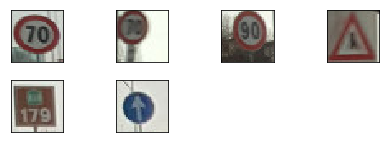

In [19]:
import os

no_of_imgs = 6
disp_imgs = []
disp_imgs_gray = []

for i in os.listdir('sign_italy/'):
    image = cv2.imread('sign_italy/'+i)
    dim = (32,32)

    # convert to grayscale
    grayed = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    disp_imgs.append(np.asarray(grayed))
    
    grayed = cv2.cvtColor(grayed, cv2.COLOR_RGB2GRAY)
    
    disp_imgs_gray.append(np.asarray(grayed))

show_signs(np.array(disp_imgs), 4,4)

# normalize new test data
test_imgs_gray = ((np.array(disp_imgs_gray)-128.0)/256.0).reshape(no_of_imgs,32,32,1)

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(meta_graph_file)
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # model evaluation
    prediction = tf.argmax(logits, 1)

    test_prediction = sess.run(
        prediction,
        feed_dict={x: test_imgs_gray, keep_prob: 1.0})
for i in range(no_of_imgs):
    print('Prediction: {} \t| {}'.format(test_prediction[i], 
                                            class_names[str(test_prediction[i])]))

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I've took some real case signs in Italy. The classification was totally wrong mainly beacuse this classes of sign are not considered in training dataset

In [20]:
# get the softmax probabilities for n best prediction probabilities.
predict_no = 5
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('sign_classify.ckpt.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # model evaluation
    prediction = tf.nn.softmax(logits)

    test_prediction = sess.run(tf.nn.top_k(
        prediction,k=predict_no),
        feed_dict={x: test_imgs_gray , keep_prob: 1.0})

# print('Predictions: {}'.format(test_prediction))

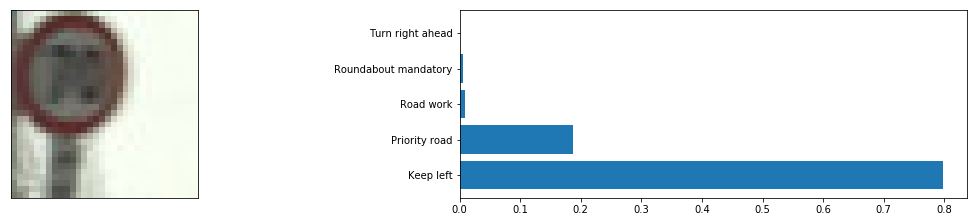

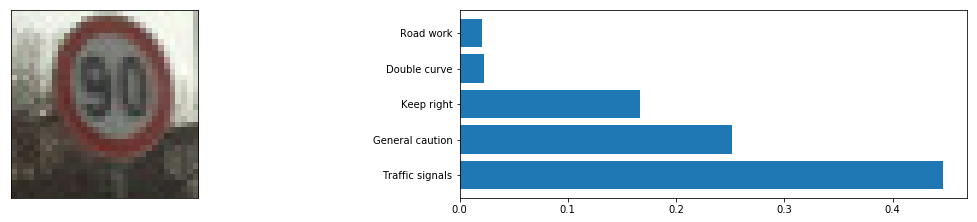

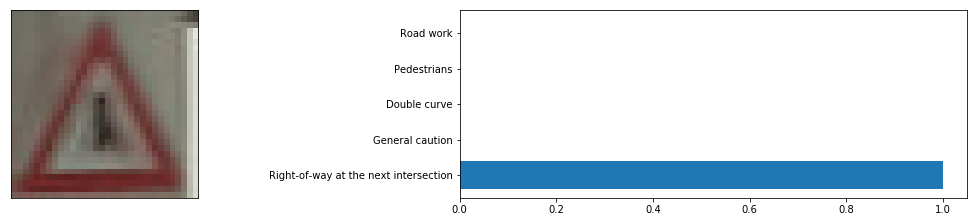

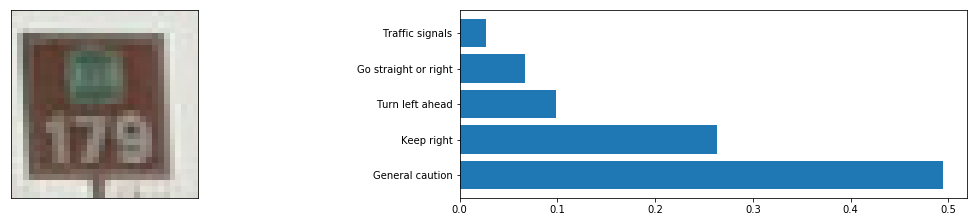

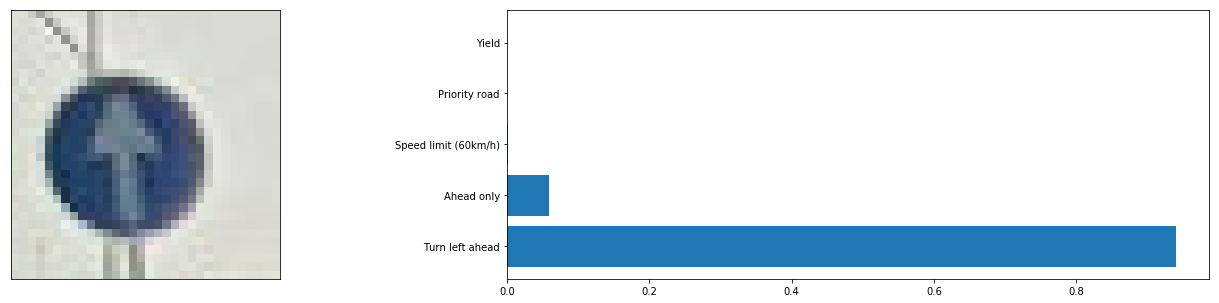

In [58]:
# plot visualization of softmax probabilities
index = np.arange(predict_no)
probabilities, predict_classes = test_prediction

candidates = [1,2,3,4,5]
for i,im in enumerate(candidates):
    fig = plt.figure(figsize=(20, 20)) 
    plt.subplot(5,2,(i+1)*2-1)
    plt.imshow(disp_imgs[im])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

    
    plt.subplot(5,2,(i+1)*2)
    plt.barh(index, probabilities[im], align='center')
    plt.yticks(index,[class_names[str(predict_classes[im][i])] for i in index] )
#     plt.axis([0,1,-0.5,2.5])

plt.tight_layout()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

I can see the model perform bad of out from previous dataset signs.
The model predicted only 1 out of 5 signs correctly ( the right-of-way sign ) so it's 20% accurate in this case. In the test set the accuracy was 94%.
Interesting the 90 Km/h sign is classified as traffic lights, maybe for the circular lines of the digits.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

About on certainty of predictions

All images shown above are new images gotten for the internet to test the performance of the model on unfamiliar images.
Image 1:
The model failed completely, maybe it handled the "7" digits as a left arrow
Image 2:
The model failed completely, I think it's all about the circular lines, quite similiar to the traffic lights sign
Image 3:
Right class of sign!ì with high score.
Image 4:
This was not in the previous dataset ok, but the classification was not so wrong, about the meaning of the sign. Good Job
Image 5:
Completely wrong, maybe the arrow a little rotated on the left made it classify it as turn left

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.